In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [3]:
# Load spaCy English Language Model
NER = spacy.load("en_core_web_sm")

### Load Books

In [4]:
import os

# Get all files  in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]


In [5]:
all_books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 something ends something begins.txt'>]

In [6]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [7]:
# Visualize identified entities
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

In [8]:
# Load character names
characters_df = pd.read_csv("characters.csv")

In [9]:
# Remove brackets and text within brackets
import re

characters_df['character'] = characters_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
characters_df['first_name'] = characters_df['character'].apply(lambda x: x.split(' ',1)[0])

<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\('
C:\Users\anton\AppData\Local\Temp\ipykernel_12588\3927780584.py:4: SyntaxWarning: invalid escape sequence '\('
  characters_df['character'] = characters_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))


In [10]:
pd.set_option('display.max_rows', None)
characters_df.head(20)

book                        character  \
0   Category:Baptism of Fire characters                           Adalia   
1   Category:Baptism of Fire characters                            Adela   
2   Category:Baptism of Fire characters                    Aen Saevherne   
3   Category:Baptism of Fire characters                         Aevenien   
4   Category:Baptism of Fire characters                           Aglaïs   
5   Category:Baptism of Fire characters                          Albrich   
6   Category:Baptism of Fire characters                           Amavet   
7   Category:Baptism of Fire characters                    Angus Bri Cri   
8   Category:Baptism of Fire characters                      Anna Kameny   
9   Category:Baptism of Fire characters                     Anzelm Aubry   
10  Category:Baptism of Fire characters                 Artaud Terranova   
11  Category:Baptism of Fire characters                             Asse   
12  Category:Baptism of Fire characters                Assire var Anahid   
13  Category:Baptism of Fire characters                           Aubry    
14  Category:Baptism of Fire characters                   Augusta Wagner   
15  Category:Baptism of Fire characters                 Baron of Casadei   
16  Category:Baptism of Fire characters                 Beatrix of Kovir   
17  Category:Baptism of Fire characters                           Bronik   
18  Category:Baptism of Fire characters                     Brouver Hoog   
19  Category:Baptism of Fire characters  Cahir Mawr Dyffryn aep Ceallach   

   first_name  
0      Adalia  
1       Adela  
2         Aen  
3    Aevenien  
4      Aglaïs  
5     Albrich  
6      Amavet  
7       Angus  
8        Anna  
9      Anzelm  
10     Artaud  
11       Asse  
12     Assire  
13      Aubry  
14    Augusta  
15      Baron  
16    Beatrix  
17     Bronik  
18    Brouver  
19      Cahir

### Get named entity list per sentence

In [11]:
sent_entity_df = []

# loop through sentences and store named list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [12]:
sent_entity_df.head()

sentence  \
0  (ï»¿The, Limits, of, the, Possible, \n, I, \n,...   
1  (", It, 's, been, an, hour, and, a, quarter, s...   
2                             (He, 's, done, for, .)   
3  (", \n, The, townsfolk, ,, huddled, together, ...   
4  (A, fat, man, dressed, in, a, yellow, smock, \...   

                          entities  
0  [ï»¿The Limits of the Possible]  
1          [an hour and a quarter]  
2                               []  
3                               []  
4                               []

In [13]:
# Function to filter out non-character entities
def filter_entity(ent_list, characters_df):
    return [ent for ent in ent_list
            if ent in list(characters_df.character)
            or ent in list(characters_df.first_name)]

In [14]:
filter_entity(["Geralt", "Thu", "4"], characters_df)

['Geralt']

In [15]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))

# filter out sentences that dont have any character entitites
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

sentence  \
85                       (I, am, Geralt, of, Rivia, .)   
95   (Is, there, anything, keeping, you, in, this, ...   
102  (", \n, ", Borch, ,, ", replied, Geralt, ,, wh...   
106  (", \n, ", There, are, some, ,, ", Geralt, rep...   
110  (", \n, Geralt, took, off, a, glove, and, shoo...   
140  (", I, forgot, ,, ", Three, Jackdaws, winked, ...   
151  (Geralt, loosened, his, belt, ,, removed, his,...   
157  (", Do, the, girls, speak, the, common, langua...   
160  (How, 's, your, soup, ,, Geralt, ?, ", \n, ", ...   
169  (Yet, there, is, a, certain, principal, underl...   

                     entities character_entities  
85          [Geralt of Rivia]  [Geralt of Rivia]  
95          [Geralt of Rivia]  [Geralt of Rivia]  
102           [Borch, Geralt]           [Geralt]  
106                  [Geralt]           [Geralt]  
110                  [Geralt]           [Geralt]  
140  [Three Jackdaws, Geralt]           [Geralt]  
151                  [Geralt]           [Geralt]  
157                  [Geralt]           [Geralt]  
160             [Geralt, Hmm]           [Geralt]  
169                  [Geralt]           [Geralt]

In [16]:
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                               for item in x])

C:\Users\anton\AppData\Local\Temp\ipykernel_12588\2555775590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [17]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

sentence  \
85                         (I, am, Geralt, of, Rivia, .)   
95     (Is, there, anything, keeping, you, in, this, ...   
102    (", \n, ", Borch, ,, ", replied, Geralt, ,, wh...   
106    (", \n, ", There, are, some, ,, ", Geralt, rep...   
110    (", \n, Geralt, took, off, a, glove, and, shoo...   
...                                                  ...   
11314  (He, only, saw, black, -, gloved, hands, squee...   
11316                                 (Oh, ,, Geralt, !)   
11321                            (Say, it, ,, Geralt, !)   
11322  (Forever, !, Say, it, !, ", \n, ", Forever, ,,...   
11327  (", \n, Yurga, saw, astonishment, in, the, eye...   

                      entities character_entities  
85           [Geralt of Rivia]           [Geralt]  
95           [Geralt of Rivia]           [Geralt]  
102            [Borch, Geralt]           [Geralt]  
106                   [Geralt]           [Geralt]  
110                   [Geralt]           [Geralt]  
...                        ...                ...  
11314                   [Ciri]             [Ciri]  
11316                 [Geralt]           [Geralt]  
11321                 [Geralt]           [Geralt]  
11322  [Forever, Ciri, Geralt]     [Ciri, Geralt]  
11327                  [Yurga]            [Yurga]  

[1696 rows x 3 columns]

### Create Relationships

In [18]:
window_size = 5
relationships = []

for i in range (sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_list) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})


In [19]:
relationship_df = pd.DataFrame(relationships)

In [20]:
pd.set_option('display.max_rows', None)
relationship_df.head()

source    target
0    Geralt  Niedamir
1    Geralt  Niedamir
2    Geralt  Niedamir
3  Niedamir    Geralt
4  Niedamir    Geralt

In [21]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns=relationship_df.columns)
relationship_df.head()

source    target
0  Geralt  Niedamir
1  Geralt  Niedamir
2  Geralt  Niedamir
3  Geralt  Niedamir
4  Geralt  Niedamir

In [22]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()

In [23]:
relationship_df.head()

source    target  value
0      Geralt  Niedamir     52
1        Eyck    Geralt     51
2  Dorregaray    Geralt     30
3  Dorregaray  Yennefer     44
4      Geralt    Yarpen     24

# Graph Analysis and Visualization

In [24]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df,
                            source="source",
                            target="target",
                            edge_attr="value",
                            create_using=nx.Graph())

### Graph Visualiztion - networkx

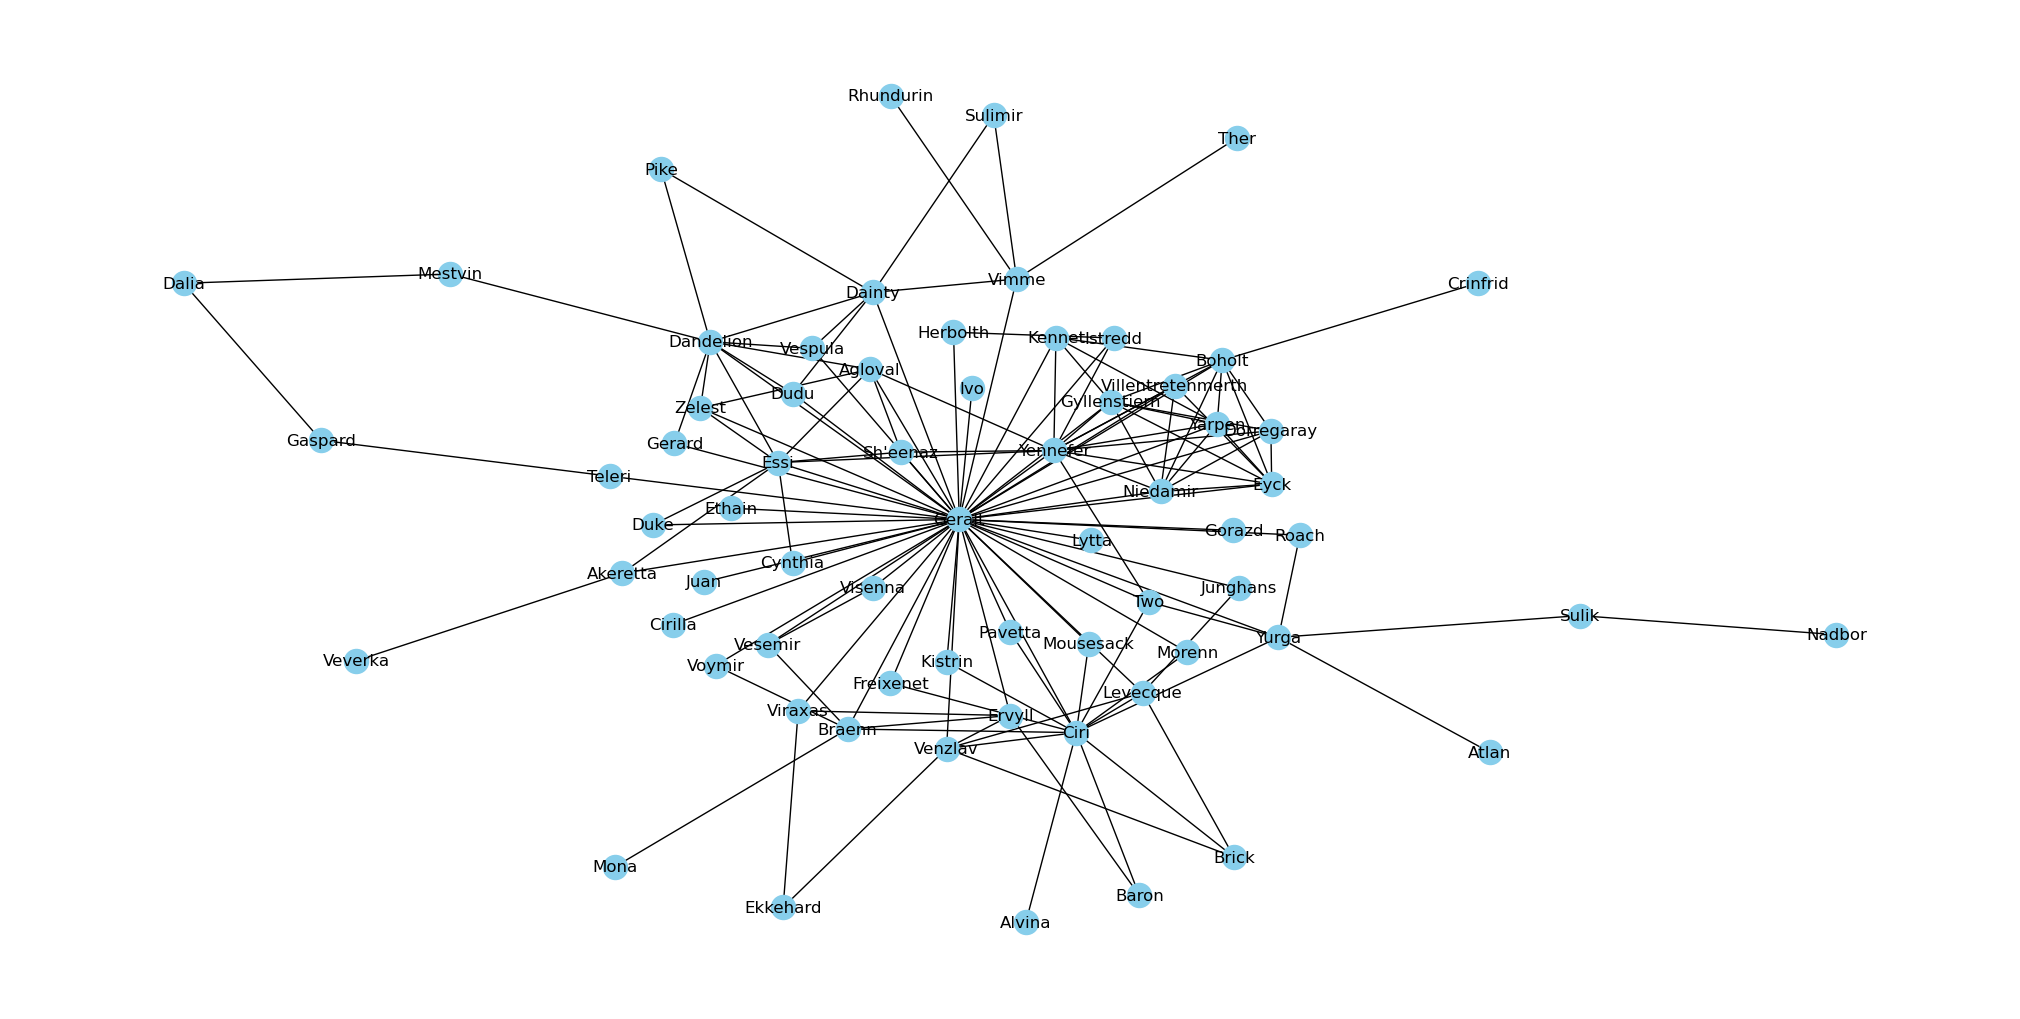

In [25]:
plt.figure(figsize=(20,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

### Graph Visualiztion - Pyvis

In [26]:
from pyvis.network import Network
net = Network(notebook=True, width="1000px", height="700px",bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show("witcher.html")

witcher.html


### The most important characters in Witcher

In [34]:
# Degree Centrality
degree_dict = nx.degree_centrality(G)

<Axes: >

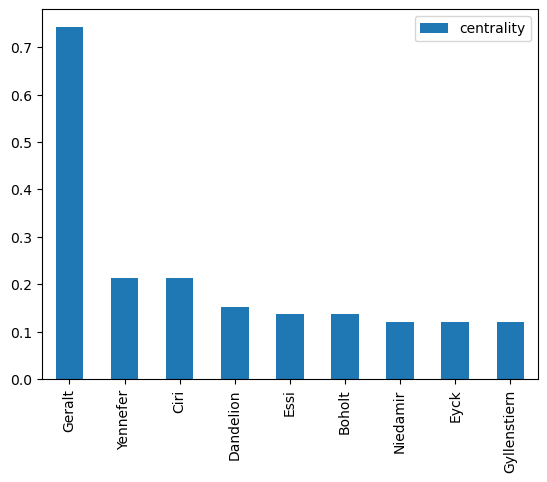

In [35]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

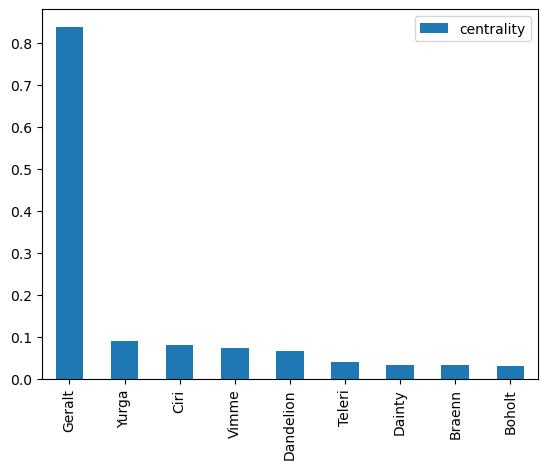

In [36]:
# betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

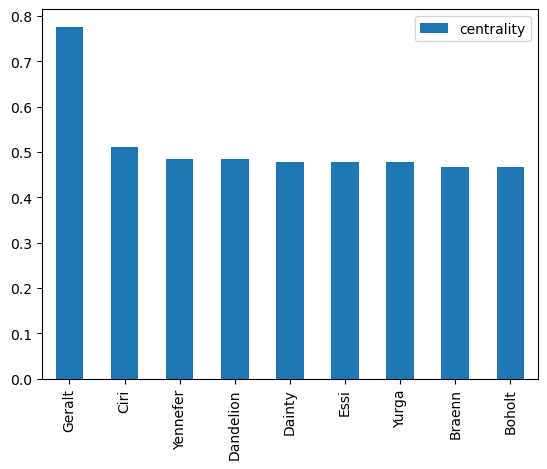

In [37]:
# Closeness Centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [38]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [40]:
import community as community_louvain

In [43]:
communities = community_louvain.best_partition(G)

In [44]:
communities

{'Geralt': 0,
 'Niedamir': 1,
 'Eyck': 1,
 'Dorregaray': 1,
 'Yennefer': 1,
 'Yarpen': 1,
 'Gyllenstiern': 1,
 'Boholt': 1,
 'Kennet': 1,
 'Crinfrid': 1,
 'Villentretenmerth': 1,
 'Istredd': 0,
 'Herbolth': 0,
 'Ivo': 0,
 'Two': 3,
 'Dandelion': 5,
 'Pike': 5,
 'Dainty': 5,
 'Vespula': 5,
 'Vimme': 5,
 'Sulimir': 5,
 'Ther': 5,
 'Rhundurin': 5,
 'Dudu': 5,
 "Sh'eenaz": 6,
 'Agloval': 6,
 'Gaspard': 2,
 'Teleri': 2,
 'Dalia': 2,
 'Mestvin': 2,
 'Essi': 6,
 'Gerard': 5,
 'Zelest': 6,
 'Duke': 6,
 'Akeretta': 6,
 'Veverka': 6,
 'Ethain': 0,
 'Juan': 0,
 'Cynthia': 6,
 'Braenn': 0,
 'Ciri': 4,
 'Ervyll': 4,
 'Voymir': 0,
 'Kistrin': 4,
 'Alvina': 4,
 'Vesemir': 0,
 'Cirilla': 0,
 'Freixenet': 4,
 'Venzlav': 4,
 'Ekkehard': 4,
 'Viraxas': 4,
 'Morenn': 4,
 'Mona': 0,
 'Pavetta': 4,
 'Baron': 4,
 'Junghans': 4,
 'Brick': 4,
 'Levecque': 4,
 'Mousesack': 4,
 'Yurga': 3,
 'Visenna': 0,
 'Atlan': 3,
 'Lytta': 0,
 'Gorazd': 0,
 'Roach': 3,
 'Nadbor': 3,
 'Sulik': 3}

In [45]:
nx.set_node_attributes(G, communities, 'group')

In [46]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

witcher_communities.html
